In [1]:
import numpy as np
import glob
import cv2
from scipy.misc import imread, imsave
from scipy.signal import find_peaks_cwt
from os.path import join
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from importlib import reload

%matplotlib inline

# setting up directory path vars
calibration_path = 'camera_cal'
examples_path = 'examples'
output_images_path = 'output_images'
output_videos_path = 'output_videos'
test_in_path = 'test_images'
test_out_path = 'test_images_out'
dump_path = 'dump'
figures_path = 'figures'

# list of test images' paths
test_in_paths = glob.glob(join(test_in_path, '*'))

# video paths
video_in_path = 'project_video.mp4'

# output paths
video_out_path = join(output_videos_path, 'project_video_out.mp4')

# set the size of inline video player
video_size = (640, 480)

# reloading all code for easier code development
import utils; reload(utils)
from utils import *

# camera calibration step (global to deal with imported namespaces)
cam = Pipeline()
mtx, dist = cam.camera_calibration(calibration_path)

# for easier switching, put all sample video paths in one list
video_paths = [video_in_path]
# display_video(video_paths[0], video_size)

In [2]:
# process an image
def pipeline(image, mtx=mtx, dist=dist, debug=False, **kwargs):
    '''
    this routine applies all steps of image processing
    to an individual image / video frame and returns
    modified image / video frame
    '''
    
    # initial internal state of pipeline
    if pip.frame_counter == 0:
        pip.height, pip.width = image.shape[:2]
        
    # this is for text label positioning
    k = 0.05
    hor = k * pip.height
    vert = (1 - k) * pip.height
    
    # STEP 1: UNDISTORT (using camera calibration step matrix and dist)
    undistorted = pip.undistort_image(image, mtx, dist)
    
    # STEP 2: GAUSSIAN BLUR
    blurred = pip.gaussian_blur(undistorted, kernel=3)
    
    # STEP 3: APPLY COLOR SPACE TRANSFORM AND SOBEL THRESHOLDING
    combined = pip.combine_binary(blurred)
    
    # STEP 4: WARP BINARY IMAGE INTO TOP-DOWN VIEW
    binary, warp_mtx, unwarp_mtx = pip.corners_unwarp(combined)

    # STEP 5: CALCULATE LEFT AND RIGHT LANE MASKS
    left_masked, right_masked, left_mask, right_mask = pip.get_lanes_mask(binary)

    # STEP 6: FIT QUADRATIC POLYNOMIAL
    fitted_left = pip.fit_line(left_masked, 'left')
    left_points = pip.get_line_points(fitted_left, left_masked)

    fitted_right = pip.fit_line(right_masked, 'right')
    right_points = pip.get_line_points(fitted_right, right_masked) 

    # STEP 7: PREPARE COLORED OVERLAY FOR FINAL VIDEO / IMAGE
    all_points, l_points, r_points = pip.prepare_poly_points(left_points, right_points)
    unwarped_overlay, overlay = pip.prepare_lane_overlay(all_points, 
                                                         l_points, 
                                                         r_points, 
                                                         image, 
                                                         unwarp_mtx)

    # STEP 8: UNWARP OVERLAY FROM TOP-DOWN VIEW BACK INTO CAMERA VIEW
    final = cv2.addWeighted(undistorted, 1, unwarped_overlay, 0.5, 0)

    # STEP 9: CALCULATE OFFSET DISTANCE AND ROAD CURVATURE
    # calculate distance and curvature
    distance = pip.distance_from_center()
    curvature = pip.get_curvature()
    
    # STEP 10: OVERLAYING OFFSET AND CURVATURE ONTO VIDEO / IMAGE
    # overlaying text on video
    font = cv2.FONT_HERSHEY_TRIPLEX
    v_hor = 50
    v_vert = 720 - v_hor
    shift = 30
    lab1 = 'off-center: {:6.2f} m'.format(distance)
    if curvature < 2000:
        lab2 = 'curvature:  {:6.0f} m'.format(curvature)
    else:
        lab2 = 'curvature:  straight'
    cv2.putText(final, lab1, (v_hor,v_vert-shift), font, 1, (255,255,255), 2)
    cv2.putText(final, lab2, (v_hor,v_vert), font, 1, (255,255,255), 2)
    
    # PLOT RESULTS FOR DEBUG / FINAL REPORT
    # save image each 100 frames
    if ((pip.frame_counter % 100) == 0) and pip.show_plots:
        # Plot the result
        rows = 4
        cols = 2
        f, ax = plt.subplots(rows, cols, figsize=(12,16))
        f.tight_layout()
        imgs = [blurred, combined, binary, left_mask + right_mask, 
                left_masked + right_masked, overlay, unwarped_overlay, final]
        names = ['Undistorted, Blurred', 'Color, Sobel Threshold', 'Warped to Top-Down', 
                 'Masks for Left / Right Lanes', 'Masked Points', 'Fitted Lanes (Top Down)', 
                 'Fitted Lanes (Camera View)', 'Final Result']
        i = 0
        for r in range(rows):
            for c in range(cols):
                ax[r, c].imshow(imgs[i], cmap='gray')
                ax[r, c].set_title('{}. '.format(i+1) + '{}'.format(names[i]), fontsize=24)
                ax[r, c].axis('off')
                
                # text overlay now handled above (redundant code)
                if names[i] == 'Finalz':
                    # text labels to be printed
                    lab1 = '{:4.2f}'.format(distance)
                    lab2 = 'radius: {:4.0f} m'.format(curvature)
                    ax[r, c].text(hor, vert, "Dst: {} m.\ncurv: {}".format(lab1, lab2), fontsize=12, color='white')
                i += 1
#         plt.suptitle(pip.frame_counter, fontsize=36)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        path_to_save = join(figures_path, '{0:0>4}.jpg'.format(pip.frame_counter))
        plt.savefig(path_to_save, bbox_inches='tight', dpi=200)
        
    pip.frame_counter += 1
    return final

def dumper(image):
    '''
    dump all frames as images to test pipeline on individual frames
    '''
    frame_count = pip.frame_counter
    
    if frame_count % 2 == 0:
        path_to_save = join(dump_path, '{0:0>4}.jpg'.format(frame_count))
        imsave(path_to_save, image)
    pip.frame_counter
    
    return image

In [3]:
# # dumping all frames for examination
# %time apply_pipeline(video_in_path, video_out_path, dumper, mtx, dist)

In [4]:
# reloading all code for easier code development
import utils; reload(utils)
from utils import *

pip = Pipeline(show_plots=False)

# testing pipeline
%time pip.apply_pipeline(video_in_path, video_out_path, pipeline, mtx, dist)

Applying video pipeline.
[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


100%|█████████▉| 1260/1261 [03:05<00:00,  6.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_out.mp4 

Apply video pipeline: SUCCESS!
CPU times: user 3min 11s, sys: 32.4 s, total: 3min 43s
Wall time: 3min 6s


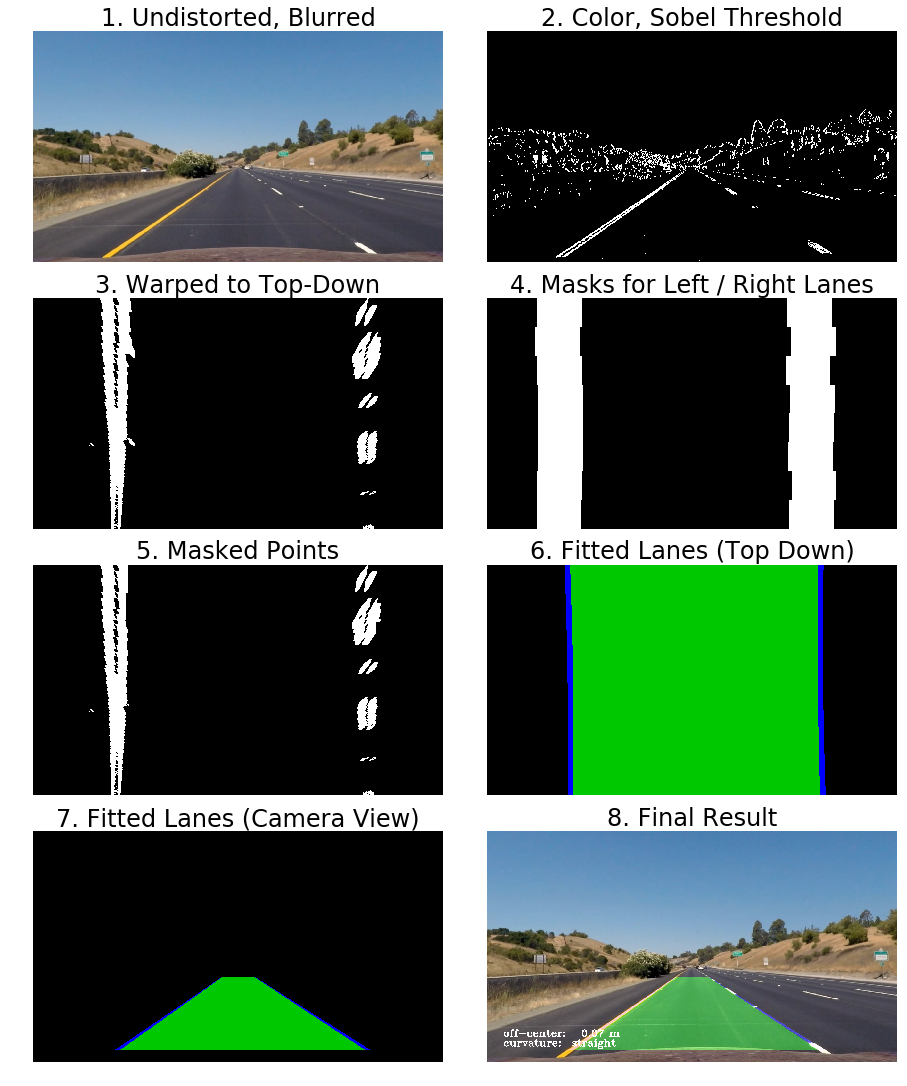

In [5]:
# reloading all code for easier code development
import utils; reload(utils)
from utils import *

pip = Pipeline(show_plots=True)

for p in test_in_paths[:1]:
    image_orig = mpimg.imread(p)
    
    final = pip.apply_pipeline(p, p, pipeline, mtx, dist)

### Let's have a look at different color space configurations of challenging frames

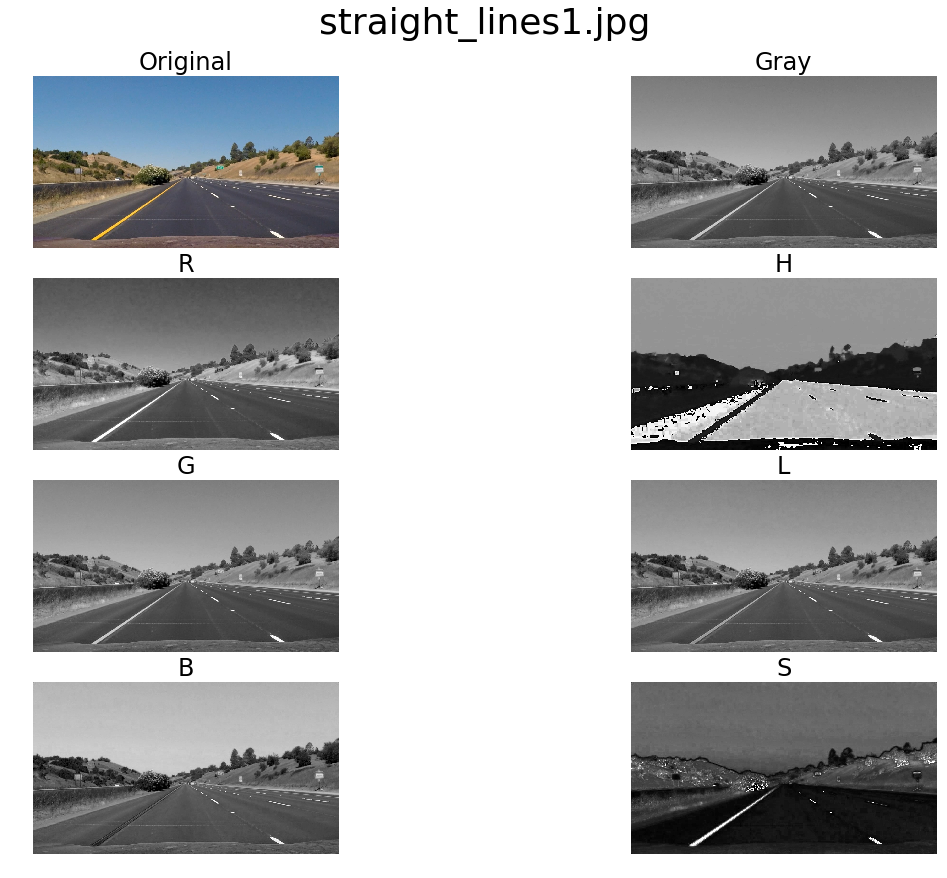

In [6]:
# reloading all code for easier code development
import utils; reload(utils)
from utils import *

pip = Pipeline(show_plots=True)

for p in test_in_paths[:1]:
    image = mpimg.imread(p)
    
#     image = eq_Hist(image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    
    # Plot the result
    rows = 4
    cols = 2
    f, ax = plt.subplots(rows, cols, figsize=(16,12))
    f.tight_layout()
    imgs = [image, gray, red, h, green, l, blue, s]
    names = ['Original', 'Gray' ,'R', 'H', 'G', 'L', 'B', 'S']
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(imgs[i], cmap='gray')
            ax[r, c].set_title('{}'.format(names[i]), fontsize=24)
            ax[r, c].axis('off')
            i += 1
    plt.suptitle(p.split('/')[-1], fontsize=36)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

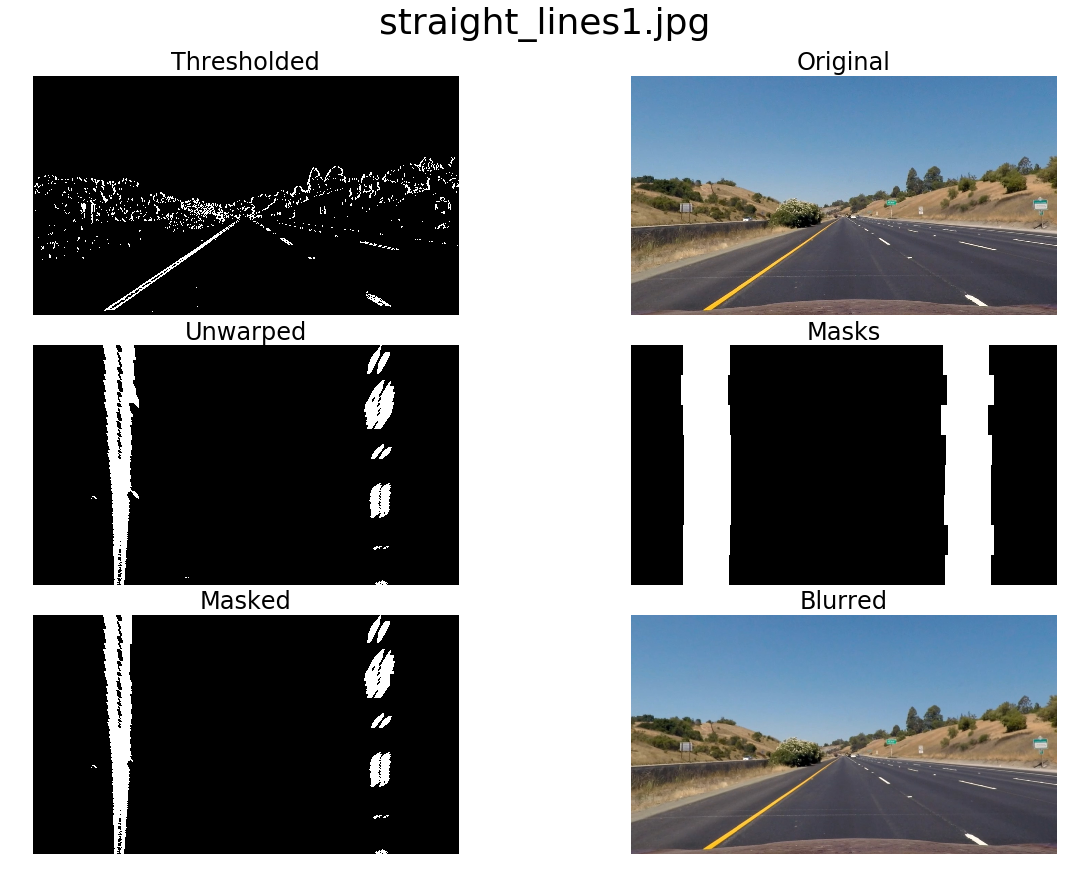

In [7]:
# reloading all code for easier code development
import utils; reload(utils)
from utils import *

pip = Pipeline(show_plots=True)

for p in test_in_paths[:1]:
    
    image = mpimg.imread(p)
    
    undistorted = pip.undistort_image(image, mtx, dist)
    
    blurred = pip.gaussian_blur(undistorted, kernel=3)
    
    combined = pip.combine_binary(blurred)
    
    unwarped, warp_mtx, unwarp_mtx = pip.corners_unwarp(combined)
    
    left_masked, right_masked, left_mask, right_mask = pip.get_lanes_mask(unwarped)

    
    # Plot the result
    rows = 3
    cols = 2
    f, ax = plt.subplots(rows, cols, figsize=(16,12))
    f.tight_layout()
    imgs = [combined, undistorted, unwarped, left_mask + right_mask, left_masked + right_masked, blurred]
    names = ['Thresholded', 'Original' ,'Unwarped', 'Masks', 'Masked', 'Blurred']
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(imgs[i], cmap='gray')
            ax[r, c].set_title('{}'.format(names[i]), fontsize=24)
            ax[r, c].axis('off')
            i += 1
    plt.suptitle(p.split('/')[-1], fontsize=36)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

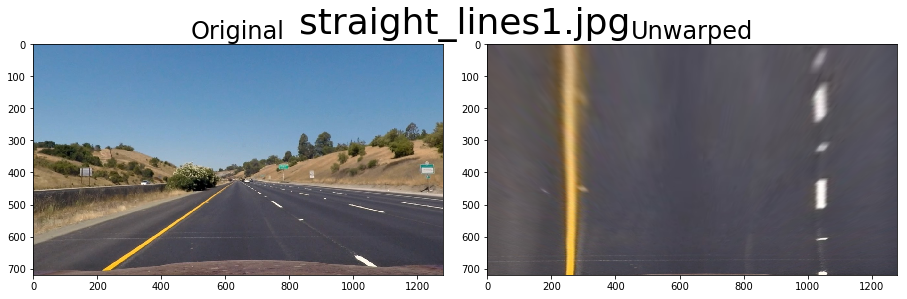

In [8]:
# reloading all code for easier code development
import utils; reload(utils)
from utils import *

pip = Pipeline(show_plots=True)

for p in test_in_paths[:1]:
    
    image = mpimg.imread(p)
    
    undistorted = pip.undistort_image(image, mtx, dist)
    
    unwarped, warp_mtx, unwarp_mtx = pip.corners_unwarp(undistorted)

    
    # Plot the result
    rows = 1
    cols = 2
    f, ax = plt.subplots(rows, cols, figsize=(12,4))
    f.tight_layout()
    imgs = [undistorted, unwarped]
    names = ['Original', 'Unwarped']
    i = 0
    for c in range(cols):
        ax[c].imshow(imgs[i], cmap='gray')
        ax[c].set_title('{}'.format(names[i]), fontsize=24)
        i += 1
    plt.suptitle(p.split('/')[-1], fontsize=36)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)